## RMOTR FINAL PROJECT 
### MACHINE LEARNING: PREDICT SALARIES

In [3]:
# Initiliaze Common Packages/Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from zipfile import ZipFile
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
# from bokeh.io import show, output_file
# from bokeh.plotting import figure

from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import binarize
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras import regularizers
# from keras.optimizers import SGD,Adam
# from keras.utils import to_categorical
# from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize': (14, 7)})

In [4]:
df_public = pd.read_csv('data/survey_results_public.csv')
df_schema = pd.read_csv('data/survey_results_schema.csv')


In [5]:
df_public.dropna(subset=['ConvertedSalary'], inplace=True)

In [6]:
q1 = df_public['ConvertedSalary'].quantile(0.25)
q3 = df_public['ConvertedSalary'].quantile(0.75)
IQR = q3 - q1
print(q1, q3, IQR)

23844.0 93000.0 69156.0


In [7]:
lb = df_public['ConvertedSalary'] >= (q1 - 1.5 * IQR)
ub = df_public['ConvertedSalary'] <= (q3 + 1.5 * IQR)

df_public = df_public[lb & ub]

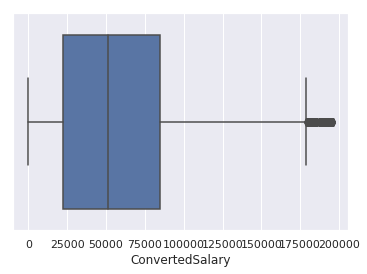

In [8]:
sns.boxplot(df_public['ConvertedSalary'])

In [9]:
df_public.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45069 entries, 1 to 89965
Columns: 129 entries, Respondent to SurveyEasy
dtypes: float64(41), int64(1), object(87)
memory usage: 44.7+ MB


In [10]:
# RECREATE SUBSET OF DATASET
sub_df = df_public.loc[:,[
    'ConvertedSalary', 
    'DevType',
    'FormalEducation',
    'YearsCoding',
    'YearsCodingProf',
    'LanguageWorkedWith',
    'DatabaseWorkedWith',
    'PlatformWorkedWith',
    'FrameworkWorkedWith',
    'Gender',
    'NumberMonitors',
    'StackOverflowVisit',
    'StackOverflowParticipate',
    'StackOverflowConsiderMember',
    'Age'
    ]]

for col in sub_df:
    if sub_df[col].dtype == object:
        sub_df[col][sub_df[col].isna()] = 'No Response'

In [11]:
sub_df.info()
# sub_df['NumberMonitors']

# sub_df['StackOverflowVisit'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45069 entries, 1 to 89965
Data columns (total 15 columns):
ConvertedSalary                45069 non-null float64
DevType                        45069 non-null object
FormalEducation                45069 non-null object
YearsCoding                    45069 non-null object
YearsCodingProf                45069 non-null object
LanguageWorkedWith             45069 non-null object
DatabaseWorkedWith             45069 non-null object
PlatformWorkedWith             45069 non-null object
FrameworkWorkedWith            45069 non-null object
Gender                         45069 non-null object
NumberMonitors                 45069 non-null object
StackOverflowVisit             45069 non-null object
StackOverflowParticipate       45069 non-null object
StackOverflowConsiderMember    45069 non-null object
Age                            45069 non-null object
dtypes: float64(1), object(14)
memory usage: 5.5+ MB


In [13]:
sub_df['NumberMonitors'] = sub_df['NumberMonitors'].astype(CategoricalDtype([
    'No Response', '1', '2', '3', '4', 'More than 4'
],ordered=True))

sub_df['StackOverflowVisit'] = sub_df['StackOverflowVisit'].astype(CategoricalDtype([
    'No Response', 'I have never visited Stack Overflow (before today)', 'Less than once per month or monthly',
    'A few times per month or weekly', 'A few times per week', 'Daily or almost daily',
    'Multiple times per day'
],ordered=True))

sub_df['StackOverflowConsiderMember'] = sub_df['StackOverflowConsiderMember'].astype(CategoricalDtype([
    'No Response', "I'm not sure", "No", "Yes"
],ordered=True))

sub_df['StackOverflowParticipate'] = sub_df['StackOverflowParticipate'].astype(CategoricalDtype([
    'No Response', 'I have never participated in Q&A on Stack Overflow', 'Less than once per month or monthly',
    'A few times per month or weekly', 'A few times per week', 'Daily or almost daily',
    'Multiple times per day'
],ordered=True))

sub_df['YearsCoding'] = sub_df['YearsCoding'].astype(CategoricalDtype([
    '0-2 years', '3-5 years', '6-8 years', '9-11 years'    
    , '12-14 years','15-17 years', '18-20 years' 
    , '21-23 years', '24-26 years', '27-29 years','30 or more years'
],ordered=True))

sub_df['YearsCodingProf'] = sub_df['YearsCodingProf'].astype(CategoricalDtype([
    '0-2 years', '3-5 years', '6-8 years', '9-11 years'    
    , '12-14 years','15-17 years', '18-20 years' 
    , '21-23 years', '24-26 years', '27-29 years','30 or more years'], ordered=True))

# sub_df['CompanySize'] = sub_df['CompanySize'].astype(CategoricalDtype([
#     'Fewer than 10 employees', '10 to 19 employees', '20 to 99 employees',
#     '100 to 499 employees', '500 to 999 employees',
#     '1,000 to 4,999 employees','5,000 to 9,999 employees', '10,000 or more employees'
# ],ordered=True))

# sub_df['JobSatisfaction'] = sub_df['JobSatisfaction'].astype(CategoricalDtype([
#     'No Response','Extremely dissatisfied', 'Moderately dissatisfied', 'Slightly dissatisfied',
#     'Neither satisfied nor dissatisfied', 'Slightly satisfied', 'Moderately satisfied', 'Extremely satisfied'
# ],ordered=True))

sub_df['FormalEducation'] = sub_df['FormalEducation'].astype(CategoricalDtype([
    'I never completed any formal education',
    'Primary/elementary school',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
    'Some college/university study without earning a degree',
    'Associate degree',
    'Bachelor’s degree (BA, BS, B.Eng., etc.)',
    'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, etc.)', 
    'Other doctoral degree (Ph.D, Ed.D., etc.)'], ordered=True))

sub_df['Age'] = sub_df['Age'].astype(CategoricalDtype([
    'Under 18 years old', '18 - 24 years old', '25 - 34 years old',
    '35 - 44 years old', '45 - 54 years old',  '55 - 64 years old'
    ,'65 years or older'
],ordered=True))

In [14]:
DevType_dummies = pd.get_dummies(sub_df['DevType'].str.split(';', expand=True).apply(lambda s: s.str.strip()).stack(), prefix='var_devtype').sum(level=0)

Language_dummies = pd.get_dummies(sub_df['LanguageWorkedWith'].str.split(';', expand=True).apply(lambda s: s.str.strip()).stack(), prefix='var_langs').sum(level=0)

Database_dummies = pd.get_dummies(sub_df['DatabaseWorkedWith'].str.split(';', expand=True).apply(lambda s: s.str.strip()).stack(), prefix='var_db').sum(level=0)

Platform_dummies = pd.get_dummies(sub_df['PlatformWorkedWith'].str.split(';', expand=True).apply(lambda s: s.str.strip()).stack(), prefix='var_pform').sum(level=0)

Framework_dummies = pd.get_dummies(sub_df['FrameworkWorkedWith'].str.split(';', expand=True).apply(lambda s: s.str.strip()).stack(), prefix='var_fwork').sum(level=0)

Gender_dummies = pd.get_dummies(sub_df['Gender'].str.split(';', expand=True).apply(lambda s: s.str.strip()).stack(), prefix='var_gender').sum(level=0)

sub_df = pd.concat([sub_df, DevType_dummies, Language_dummies, Database_dummies, Platform_dummies, Framework_dummies],axis=1)

In [15]:
sub_df['CountLanguageWorkedWith'] = [0 if v == 'No Response' else len(v.split(';')) for v in sub_df['LanguageWorkedWith']]
sub_df['CountDBWorkedWith'] = [0 if v == 'No Response' else len(v.split(';')) for v in sub_df['DatabaseWorkedWith']]
sub_df['CountPlatformWorkedWith'] = [0 if v == 'No Response' else len(v.split(';')) for v in sub_df['PlatformWorkedWith']]
sub_df['CountFrameworkWorkedWith'] = [0 if v == 'No Response' else len(v.split(';')) for v in sub_df['FrameworkWorkedWith']]

In [21]:
sub_df.head()

,ConvertedSalary,FormalEducation,YearsCoding,YearsCodingProf,NumberMonitors,StackOverflowVisit,StackOverflowParticipate,StackOverflowConsiderMember,Age,var_devtype_Back-end developer,...,var_fwork_React,var_fwork_Spark,var_fwork_Spring,var_fwork_TensorFlow,var_fwork_Torch/PyTorch,var_fwork_Xamarin,CountLanguageWorkedWith,CountDBWorkedWith,CountPlatformWorkedWith,CountFrameworkWorkedWith
1,70841.0,5,10,6,2,3,3,3,3,0,...,0,0,0,0,0,0,3,3,1,1
4,21426.0,3,2,0,2,5,2,3,1,0,...,0,0,0,0,0,0,7,4,2,0
5,41671.0,5,2,1,2,3,2,2,1,1,...,0,0,0,0,0,0,6,1,1,2
6,120000.0,3,3,0,2,6,1,2,1,1,...,1,0,0,0,0,0,3,1,1,2
14,0.0,2,0,0,2,5,2,2,1,1,...,0,0,0,0,0,0,6,2,1,0


In [18]:
sub_df['YearsCoding'] = sub_df['YearsCoding'].values.codes
sub_df['YearsCodingProf'] = sub_df['YearsCodingProf'].values.codes
sub_df['FormalEducation'] = sub_df['FormalEducation'].values.codes
sub_df['Age'] = sub_df['Age'].values.codes
sub_df['NumberMonitors'] = sub_df['NumberMonitors'].values.codes
sub_df['StackOverflowVisit'] = sub_df['StackOverflowVisit'].values.codes
sub_df['StackOverflowParticipate'] = sub_df['StackOverflowParticipate'].values.codes
sub_df['StackOverflowConsiderMember'] = sub_df['StackOverflowConsiderMember'].values.codes
# sub_df['CompanySize'] = sub_df['CompanySize'].values.codes


AttributeError: 'numpy.ndarray' object has no attribute 'codes'

In [20]:
del sub_df['DevType']
del sub_df['LanguageWorkedWith']
del sub_df['DatabaseWorkedWith']
del sub_df['PlatformWorkedWith']
del sub_df['FrameworkWorkedWith']
del sub_df['Gender']

In [22]:
sub_df.head()

,ConvertedSalary,FormalEducation,YearsCoding,YearsCodingProf,NumberMonitors,StackOverflowVisit,StackOverflowParticipate,StackOverflowConsiderMember,Age,var_devtype_Back-end developer,...,var_fwork_React,var_fwork_Spark,var_fwork_Spring,var_fwork_TensorFlow,var_fwork_Torch/PyTorch,var_fwork_Xamarin,CountLanguageWorkedWith,CountDBWorkedWith,CountPlatformWorkedWith,CountFrameworkWorkedWith
1,70841.0,5,10,6,2,3,3,3,3,0,...,0,0,0,0,0,0,3,3,1,1
4,21426.0,3,2,0,2,5,2,3,1,0,...,0,0,0,0,0,0,7,4,2,0
5,41671.0,5,2,1,2,3,2,2,1,1,...,0,0,0,0,0,0,6,1,1,2
6,120000.0,3,3,0,2,6,1,2,1,1,...,1,0,0,0,0,0,3,1,1,2
14,0.0,2,0,0,2,5,2,2,1,1,...,0,0,0,0,0,0,6,2,1,0


In [23]:
# Choosing factors by column index from our overall dataframe
names_of_x_columns = sub_df.columns[1:]

# The Xs to buil the model with (as numpy array)
X = sub_df.iloc[:,1:].values

# The output we'd like to model is 'ConvertedSalary'
y = sub_df.iloc[:,0].values

# Print stuff:
print("size of input data:", X.shape)
print("size of output data:", y.shape)

size of input data: (45069, 134)
size of output data: (45069,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=25)

print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of training set: (36055, 134)
Size of test set: (9014, 134)


### Linear Regression Model

In [25]:
# Define Linear Regression object
regr = LinearRegression()

# Train the model using your training data
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

lr_result_df = pd.concat([pd.Series(y_pred),pd.Series(y_test)], axis=1)
lr_result_df.columns = ['predicted','actual']

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 1.22596969e+03  2.23392524e+03  4.87700032e+03  6.85770093e+03
 -2.07823770e+03 -3.77366705e+02  5.10489522e+02  3.12450902e+03
 -1.39686548e+03 -3.50592810e+03 -6.05209706e+02  1.83604580e+03
 -2.92428458e+03 -2.56713005e+03 -1.58401880e+03  2.54268680e+03
 -6.71567912e+03 -1.31542078e+02  1.00951085e+04 -1.03254211e+02
  2.27035986e+03 -4.13583418e+03  7.17690754e+02 -2.72135034e+03
  4.07598054e+03 -5.33681397e+01 -9.84455459e+02 -1.43596946e+04
 -3.66620284e+03  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638064e+15  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638064e+15  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638064e+15  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638064e+15  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638064e+15  1.41638064e+15  1.41638064e+15  1.41638064e+15
  7.16787500e+03  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638064e+15  1.41638064e+15  1.41638064e+15  1.41638064e+15
  1.41638

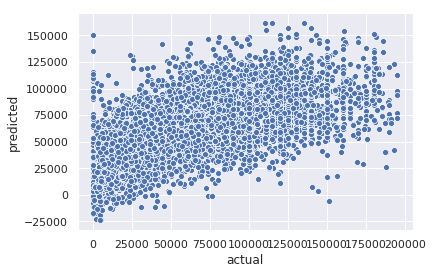

In [26]:
sns.scatterplot(data=lr_result_df, x='actual', y='predicted')

### Ridge Regression Model

In [27]:
# Define Ridge Regression object
regr = Ridge(alpha=.5)

# Train the model using your training data
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

r_result_df = pd.concat([pd.Series(y_pred),pd.Series(y_test)], axis=1)
r_result_df.columns = ['predicted','actual']

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [  1227.05759902   2233.79286788   4876.47220631   6856.70365986
  -2078.06276794   -377.54593467    509.96417168   3123.09429696
  -1394.82730802  -3503.78422838   -612.31112988   1832.9780215
  -2921.60487877  -2563.08725989  -1585.97972559   2543.2548521
  -6712.50804933   -134.94471293  10091.48670086   -101.50843229
   2270.66300905  -4136.12967651    714.91417533  -2721.27365245
   4056.01841458    -53.4905701    -986.24456939 -14357.50642809
  -3664.26543174  -2015.34993873   6207.67068223  -4063.95977263
   1100.7938851    -271.9633706     -46.74684907   2198.21014679
  -3093.06314521    336.86077482 -13253.80974337    711.15561807
   3712.79179994   6168.23260562   3881.77669202  -3246.52706985
  10509.94577717   -760.72365029  -1009.0353335    -757.48427162
  -4175.57736889   1769.67576544  -2205.35999316  -2788.22582072
   7158.15149778   -519.81527457   4065.82419912  -8402.03347958
    147.48076621   3831.27090896    537.56397995   5019.35064071
   2766.371

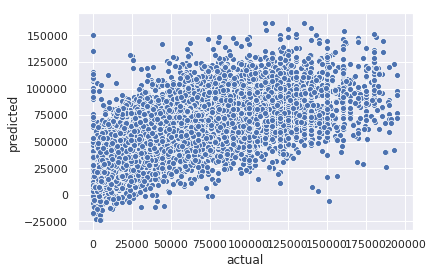

In [28]:
sns.scatterplot(data=r_result_df, x='actual', y='predicted')

### Lasso Regression Model

In [29]:
# Define Lasso Regression object
regr = Lasso(alpha=0.1)

# Train the model using your training data
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

lasso_result_df = pd.concat([pd.Series(y_pred),pd.Series(y_test)], axis=1)
lasso_result_df.columns = ['predicted','actual']

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [  1226.95128724   2233.85222241   4876.45288474   6856.75054505
  -2078.08889886   -377.46363488    509.65166621   3123.02953905
  -1394.8009086   -3501.853305     -610.60552258   1831.05030771
  -2921.54324907  -2562.86308146  -1585.75872259   2542.49128048
  -6712.15417358   -133.92357     10092.13523874   -101.18823295
   2269.97396322  -4134.52252977    702.51129702  -2720.55092073
   4049.31327643    -51.31983988   -985.29765052 -14359.30047434
  -3663.91376831  -1092.54685442   7128.96642077  -3142.43642488
   2021.38069502    648.0883514     870.56310744   3115.79453579
  -2158.24188265   1255.1539628  -12337.65708796   1626.18256367
   4632.27079537   7089.93486568   4801.95099365  -2321.70130943
  11454.14453529    157.3197726     -87.42774136    163.07785558
  -3243.37273036   2689.36065172  -1281.30996908  -1865.29311192
   7156.97315837    399.49070851   4978.75222368  -7481.27823055
   1066.38978466   4752.63880393   1457.26852992   5941.30029812
   3686.1

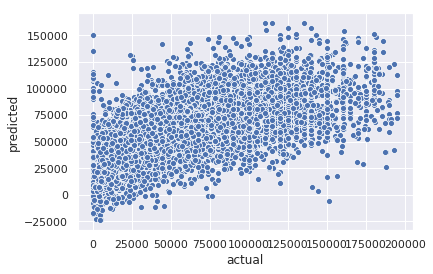

In [30]:
sns.scatterplot(data=lasso_result_df, x='actual', y='predicted')